In [1]:
%matplotlib inline

# 计算机视觉分类

在本教程中，您将学习如何使用迁移学习训练卷积神经网络进行图像分类。你可以在 [cs231n notes](https://cs231n.github.io/transfer-learning/) 中阅读更多关于迁移学习的信息。

```{note}
在实践中，很少有人从零开始（使用随机初始化）训练整个卷积网络，因为拥有足够大的数据集是相对罕见的。相反，通常是在非常大的数据集（例如 ImageNet，包含 120 万张包含 1000 个类别的图像）上预训练卷积神经网络，然后使用卷积神经网络作为初始化或用于感兴趣的任务的固定特征提取器。
```

这两种主要的迁移学习场景如下：

1. **微调 ConvNet**：该模型不是随机初始化，而是使用预训练的网络初始化，之后的训练照常进行，但使用不同的数据集。如果有不同数量的输出，通常也替换网络中的头（或它的一部分）。在这种方法中，通常将学习速率设置为较小的数值。之所以这样做，是因为网络已经经过了训练，只需要稍作修改就可以将其“微调”到新的数据集。

2. **ConvNet 作为固定的特征提取器**：在这里，你 [“冻结”](https://arxiv.org/abs/1706.04983) 除了最后几个层（又名“头部”，通常是全连接的层）之外，网络中所有参数的权重。这些最后的层将被替换为新层，并初始化为随机权重，只有这些层会被训练。

你也可以将以上两种方法结合使用：首先，你可以冻结特征提取器，训练头部。在此之后，您可以解冻特征提取器（或部分特征提取器），将学习速率设置为较小的值，然后继续训练。

In [2]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.backends import cudnn
import torchvision
from torchvision import models
from matplotlib import pyplot as plt

# 让程序在开始时花费一点额外时间，
# 为整个网络的每个卷积层搜索最适合它的卷积实现算法，进而实现网络的加速。
cudnn.benchmark = True

plt.ion()   # 交互模式

# 载入自定义模块
from mod import load_mod
load_mod()

```{admonition} 任务
训练对蚂蚁和蜜蜂进行分类的模型。
```

```{rubric} 加载数据
```

通常，如果从零开始训练，这是一个非常小的可泛化的数据集。由于使用迁移学习，应该能够相当好地推广。

本文自定义数据加载器 {class}`~pytorch_book.datasets.examples.Hymenoptera`：

In [3]:
from pytorch_book.datasets.examples import Hymenoptera
# 加载数据
loader = Hymenoptera()

```{rubric} 训练模型
```

写一个通用函数 {func}`~tools.train_model` 来训练模型：

-  调度学习率
-  保存最佳模型

In [4]:
from tools import train_model

```{rubric} 可视化模型预测
```

{meth}`~xinet.ModuleTool.imshow` 显示预测的一些图像的通用函数：

In [5]:
from xinet import ModuleTool, CV

```{rubric} 设置设备
```

设置模型训练的设备：

In [6]:
import torch

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## 微调 ConvNet

加载预训练模型，重置最终的全连接层。

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# 这里每个输出样本的大小设置为 2。
# 或者，它可以推广到 ``nn.Linear(num_ftrs, len(class_names))``。
model_ft.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()

# 观测所有被优化的参数
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

```{rubric} 训练和评估
```

在 CPU 上应该需要大约 15-25 分钟。而在 GPU 上，这只需要不到一分钟的时间。

loss 0.620, train acc 0.680, test acc 0.902
99.5 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2)]


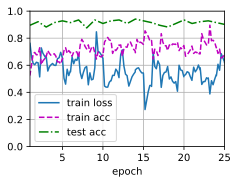

In [8]:
train_iter = loader.dataloaders['train']
test_iter = loader.dataloaders['val']
CV.train_fine_tuning(model_ft, train_iter, test_iter,
                     learning_rate=1e-3,
                     num_epochs=25,
                     param_group=False)

In [9]:
# model_ft = train_model(model_ft,
#                        loader,
#                        criterion,
#                        optimizer_ft,
#                        exp_lr_scheduler,
#                        num_epochs=25,
#                        device=device)

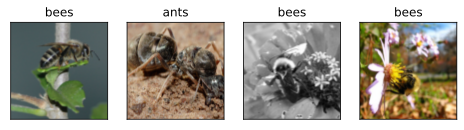

In [10]:
for xs, _ in loader.dataloaders['val']:
    break

MT = ModuleTool(xs)
MT.imshow(model_ft, loader.class_names, device,
          num_rows=1, num_cols=4, scale=2);

## ConvNet 作为固定的特征提取器

在这里，需要冻结除了最后一层之外的所有网络。需要设置 ``requires_grad = False`` 来冻结参数，这样梯度就不会在 ``backward()`` 中计算出来。

也可以阅读 [excluding-subgraphs-from-backward](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward) 了解更多内容。


In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# 新构造模块的参数默认为 requires_grad=True
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 观察到只有最后一层的参数被优化，而不是之前。
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

```{rubric} 训练和评估
```

在 CPU 上，与之前的场景相比，这将花费大约一半的时间。这是预期的，因为梯度不需要计算的大多数网络。但是，forward 确实需要计算。

loss 0.541, train acc 0.730, test acc 0.954
132.0 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2)]


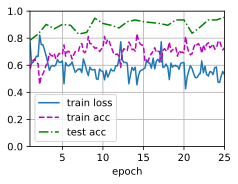

In [12]:
CV.train_fine_tuning(model_conv, train_iter, test_iter,
                     learning_rate=1e-3,
                     num_epochs=25,
                     param_group=False)

In [ ]:
# model_conv = train_model(model_conv, loader, criterion, optimizer_conv,
#                          exp_lr_scheduler, num_epochs=25, device=device)

```{rubric} 可视化
```

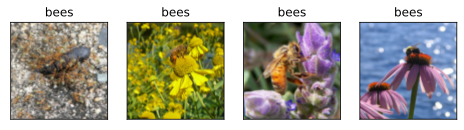

In [13]:
for xs, _ in loader.dataloaders['val']:
    break

MT = ModuleTool(xs)
MT.imshow(model_ft, loader.class_names, device,
          num_rows=1, num_cols=4, scale=2)
plt.ioff()
plt.show()